Loaded 17 metrics:
['ec2_cpu_utilization_77c1ca', 'rds_cpu_utilization_e47b3b', 'elb_request_count_8c0756', 'ec2_cpu_utilization_c6585a', 'grok_asg_anomaly', 'ec2_network_in_5abac7', 'ec2_disk_write_bytes_1ef3de', 'rds_cpu_utilization_cc0c53', 'ec2_cpu_utilization_24ae8d', 'ec2_disk_write_bytes_c0d644', 'iio_us-east-1_i-a2eb1cd9_NetworkIn', 'ec2_network_in_257a54', 'ec2_cpu_utilization_fe7f93', 'ec2_cpu_utilization_ac20cd', 'ec2_cpu_utilization_825cc2', 'ec2_cpu_utilization_53ea38', 'ec2_cpu_utilization_5f5533']
Could not find 'grok_asg' in loaded data.

ec2_cpu_utilization_77c1ca shape: (4032, 2)
            timestamp  value
0 2014-04-02 14:25:00  0.068
1 2014-04-02 14:30:00  0.102
2 2014-04-02 14:35:00  0.100
3 2014-04-02 14:40:00  0.098
4 2014-04-02 14:45:00  0.102

rds_cpu_utilization_e47b3b shape: (4032, 2)
            timestamp   value
0 2014-04-10 00:02:00  14.012
1 2014-04-10 00:07:00  13.334
2 2014-04-10 00:12:00  15.000
3 2014-04-10 00:17:00  13.998
4 2014-04-10 00:22:00  14.

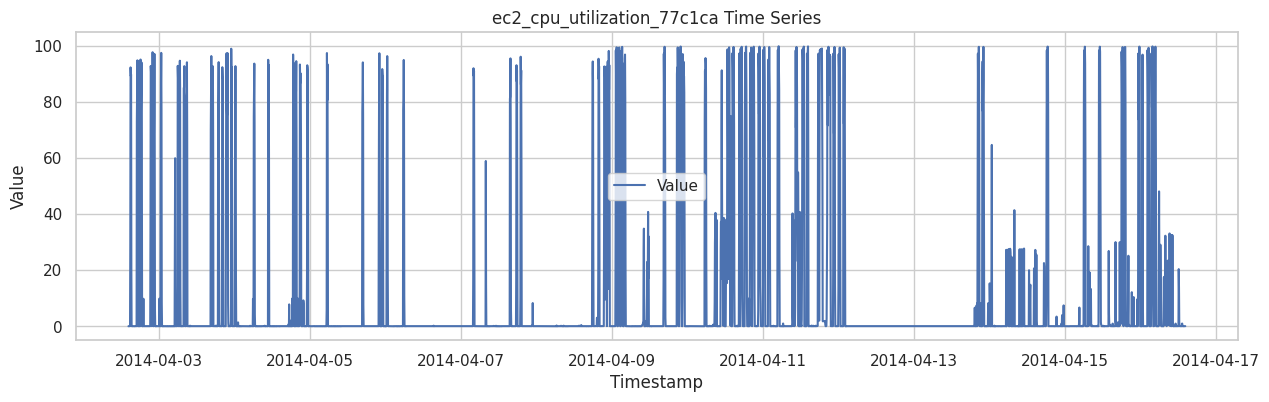

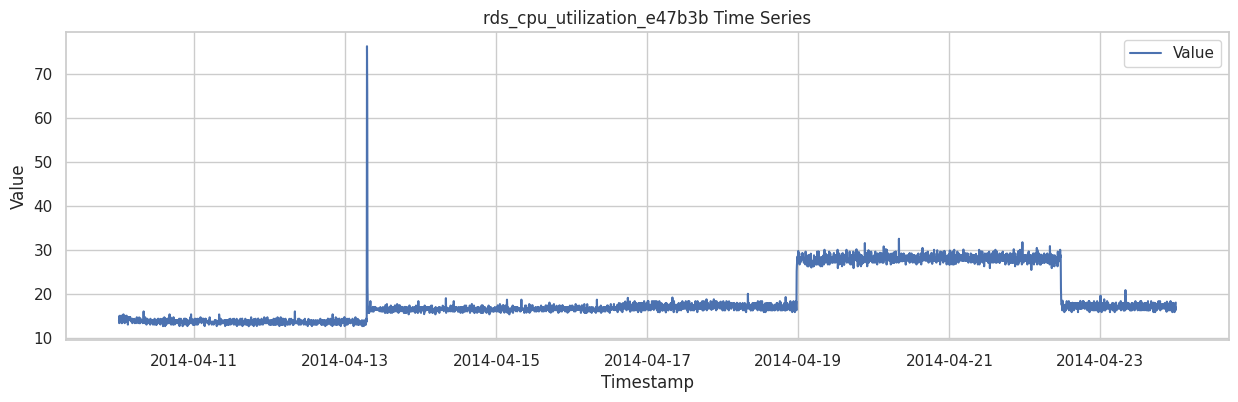

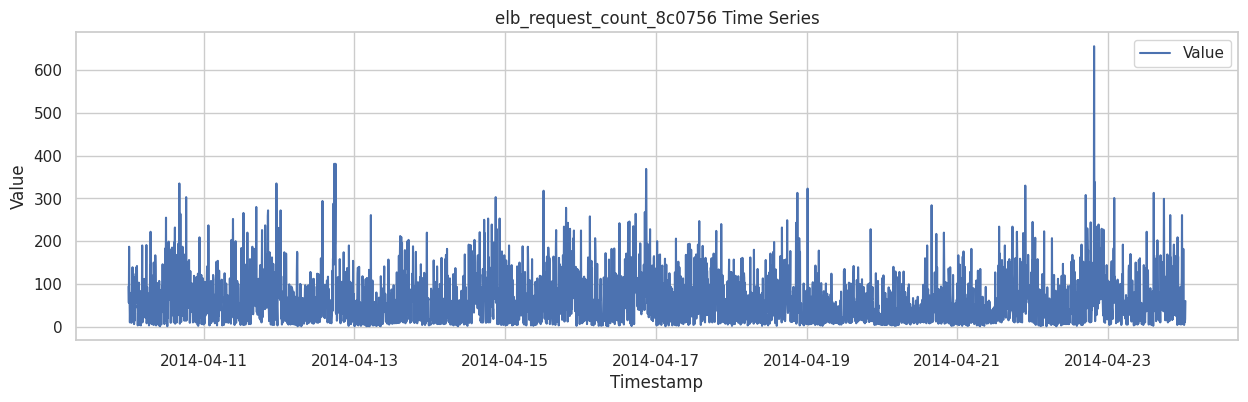

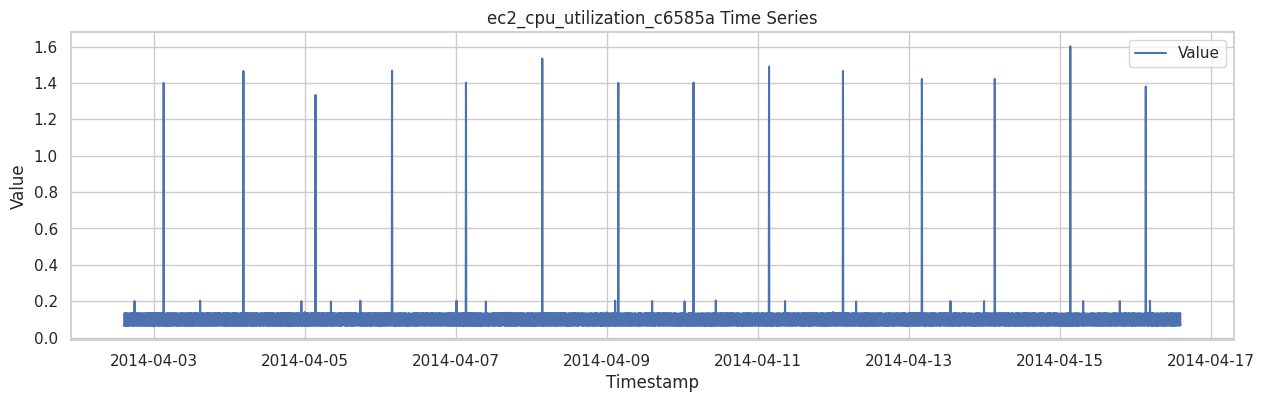

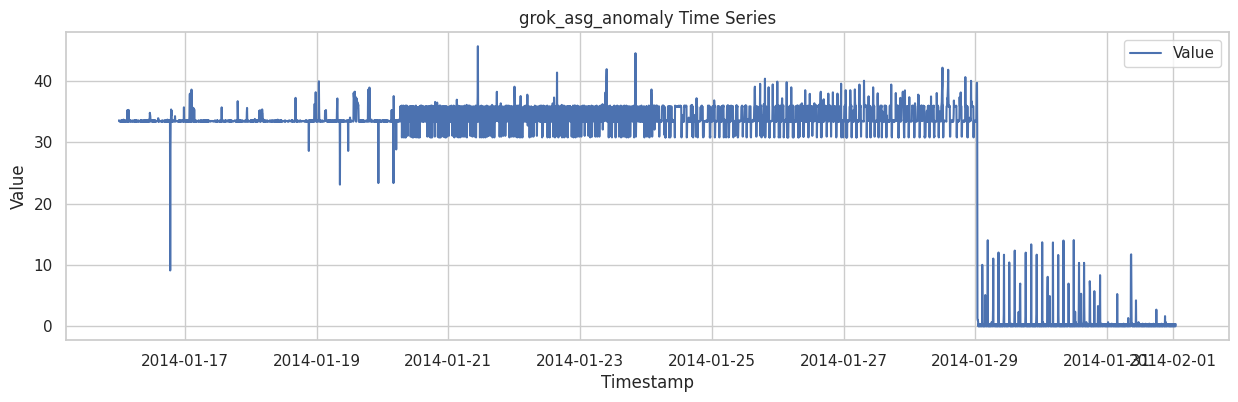

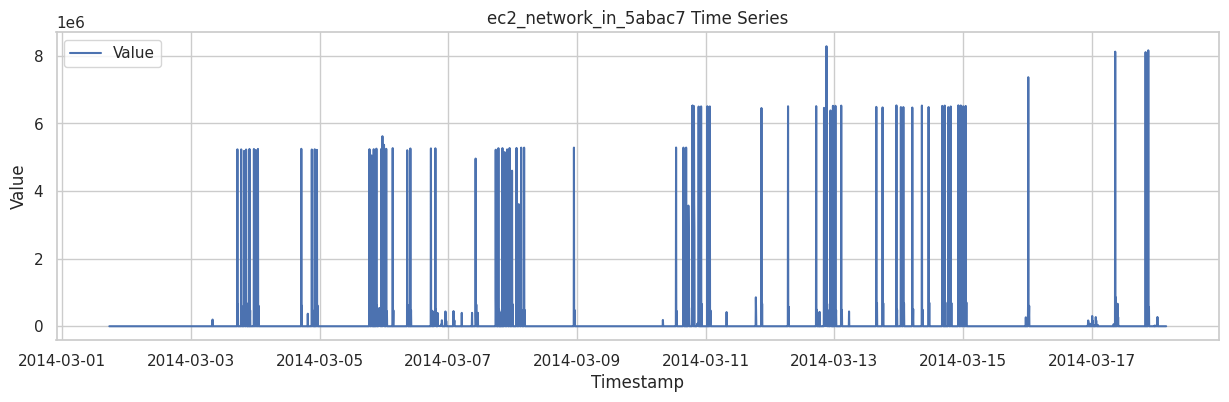

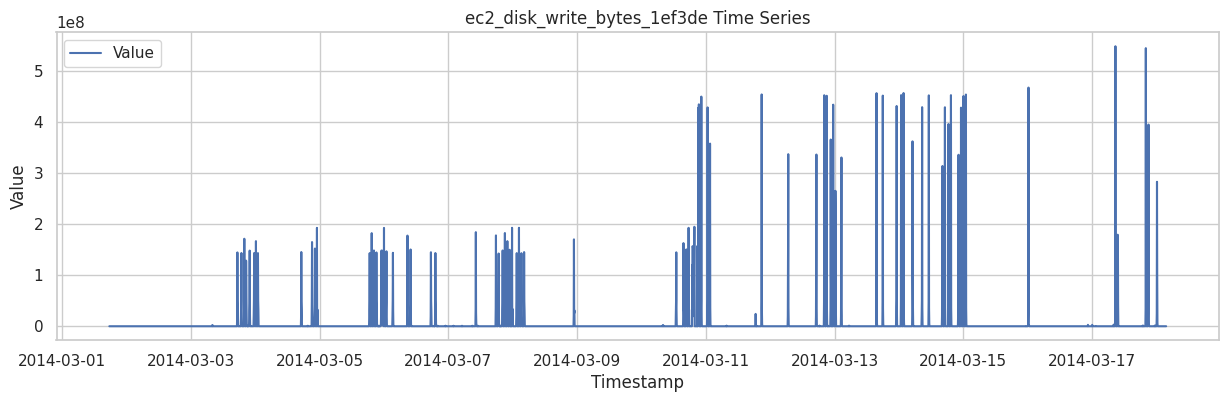

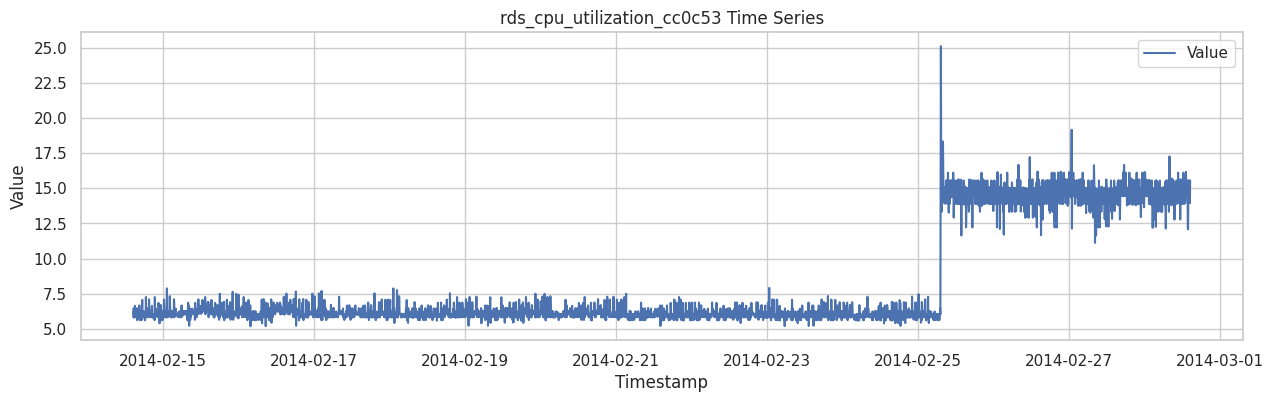

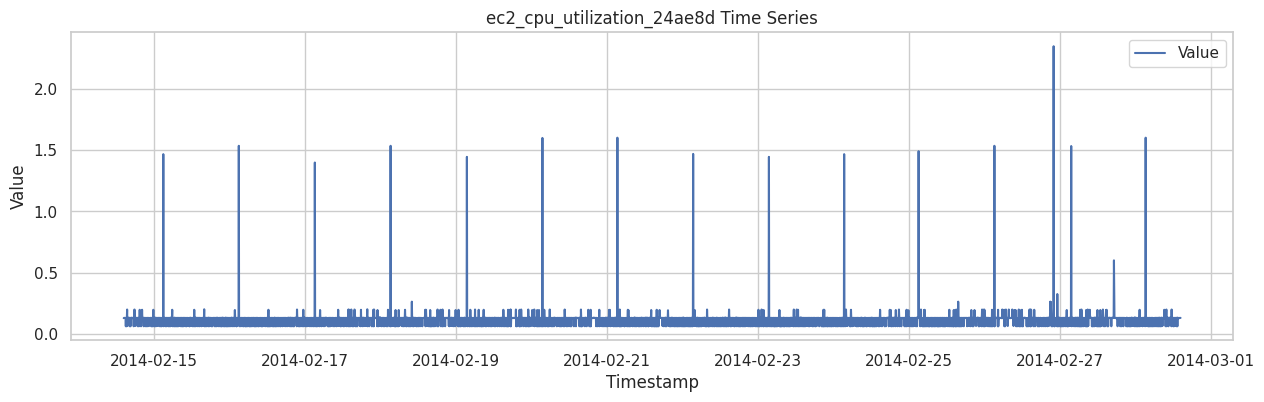

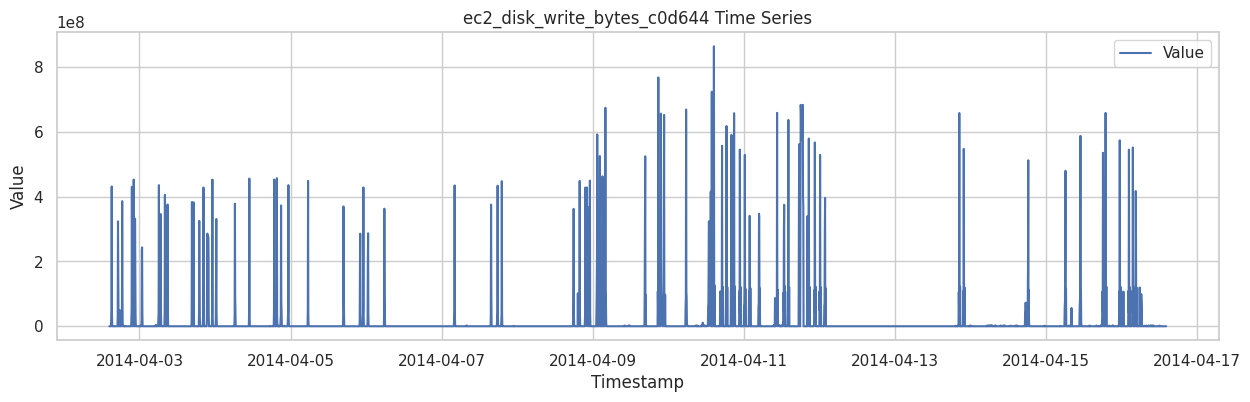

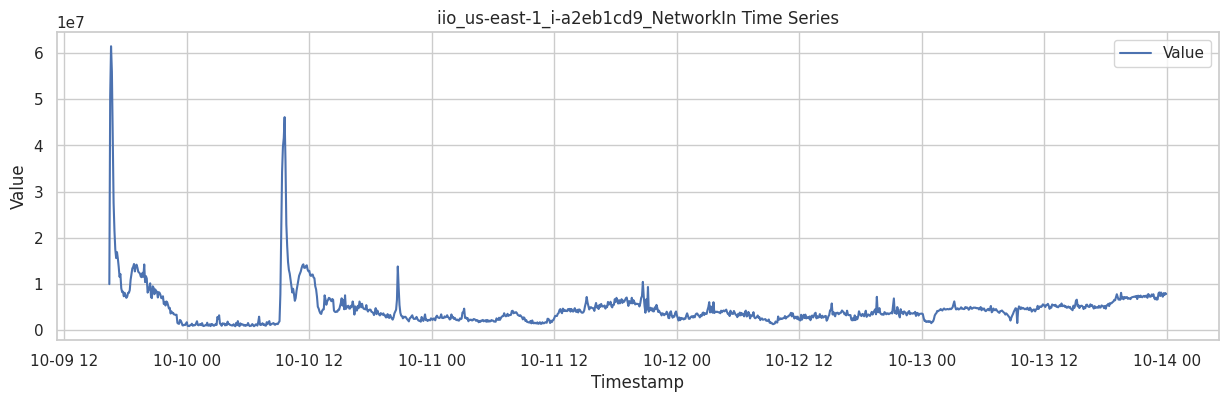

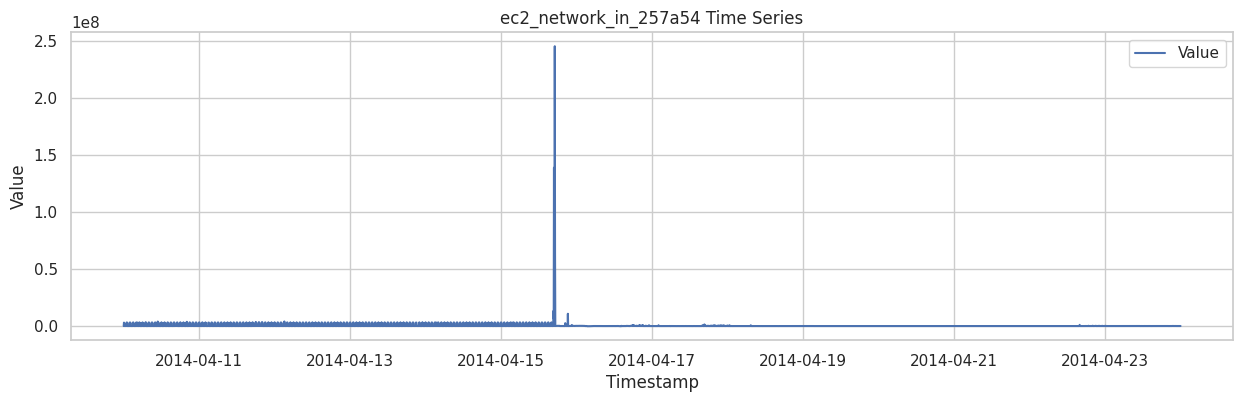

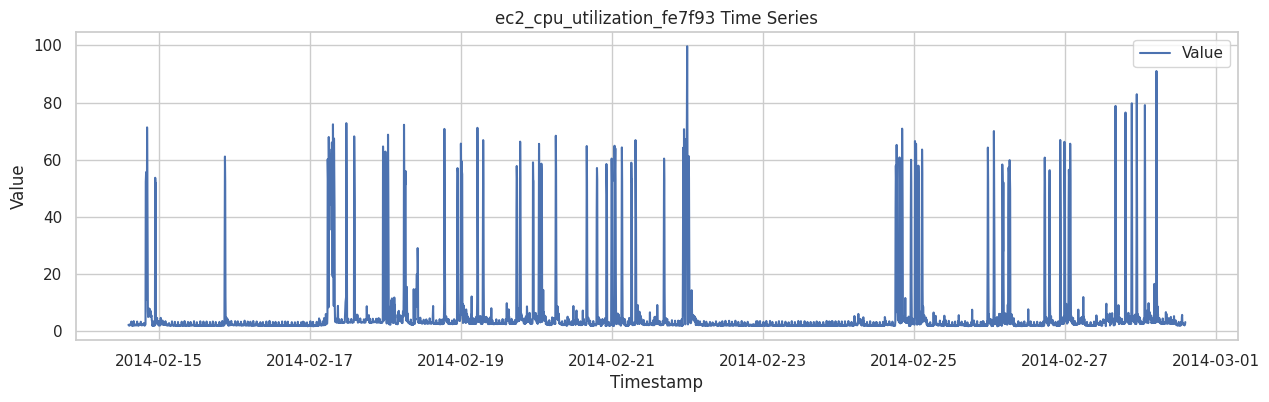

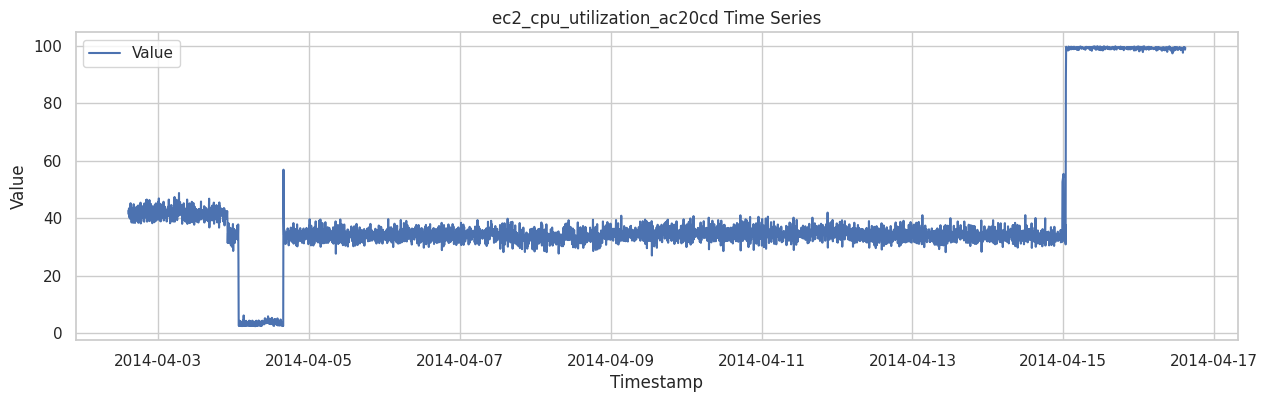

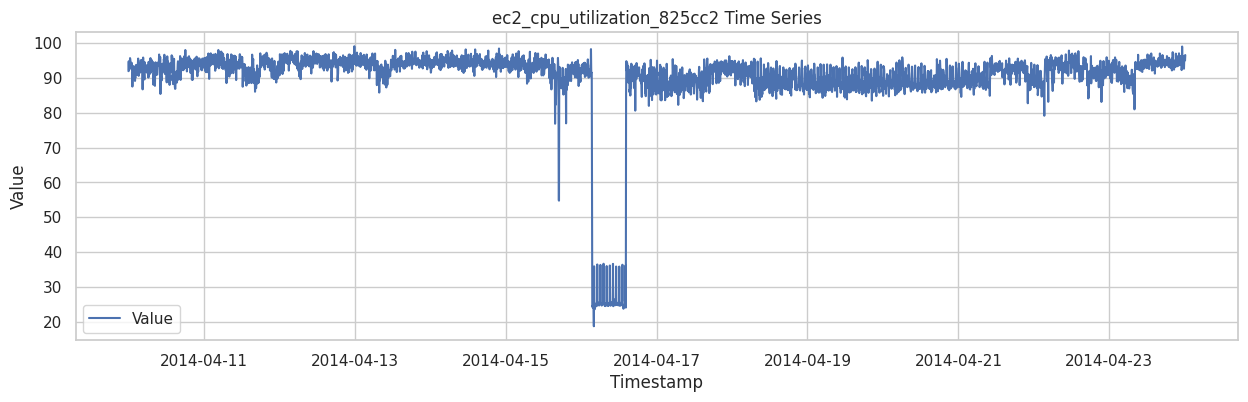

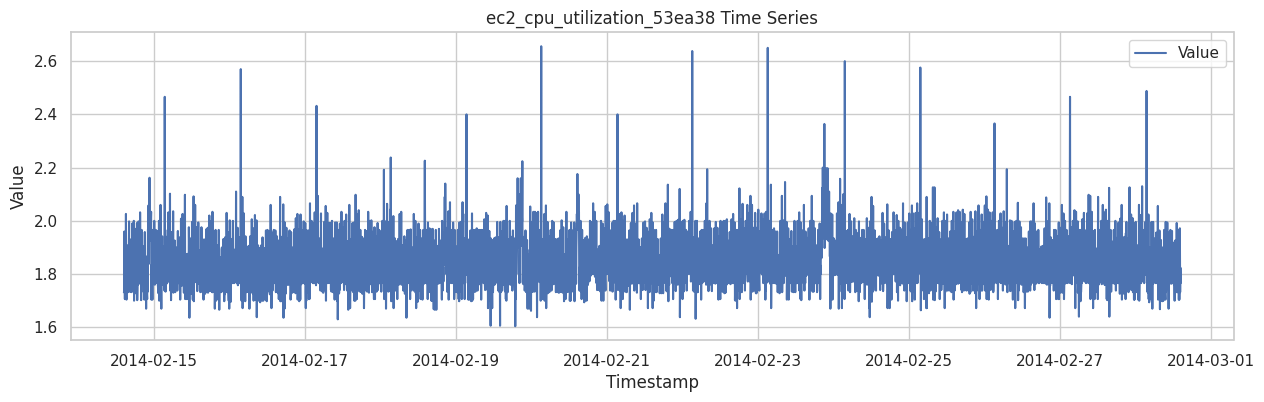

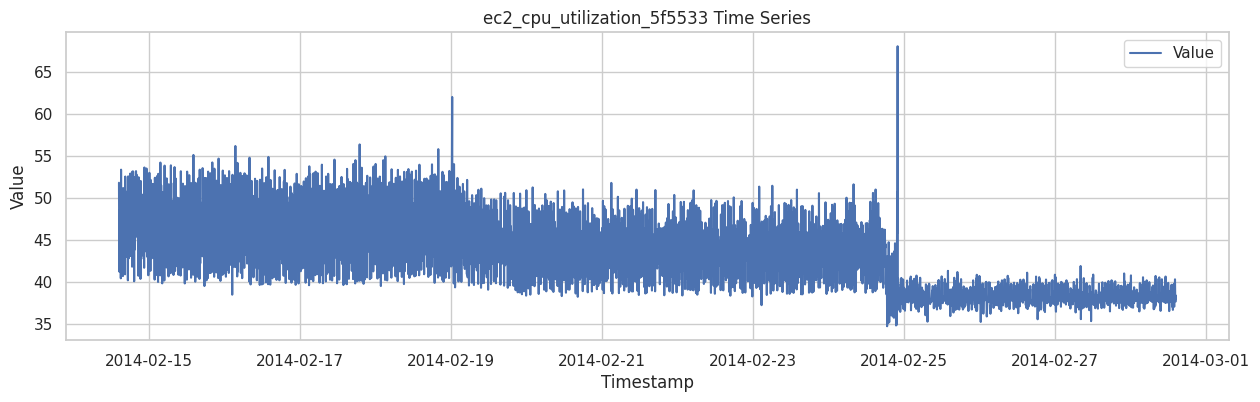


Anomaly Event Summary:
Empty DataFrame
Columns: []
Index: []


In [3]:
# EDA for AWS CloudWatch Data (NAB Dataset)

# --- Ensure src/ is in Python path for imports ---
import sys
import os

# If running from "notebooks/" directory, add "../src" to sys.path
sys.path.append(os.path.abspath("../src"))

# --- Imports ---
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from data_ingestion.loader import load_aws_cloudwatch_data

# Set up plotting
%matplotlib inline
sns.set(style='whitegrid')

# ---- Load All Time Series ----
data_dir = "../data/raw/aws_cloudwatch_data"  # Adjust path as needed
data = load_aws_cloudwatch_data(data_dir)
print(f"Loaded {len(data)} metrics:")
print(list(data.keys()))

# ---- Integrate Anomaly Labels from Anomaly CSV ----
anomaly_file = "../data/raw/aws_cloudwatch_data/grok_asg_anomaly.csv"
if os.path.exists(anomaly_file):
    anomaly_df = pd.read_csv(anomaly_file, parse_dates=['timestamp'])
    anomaly_timestamps = set(anomaly_df['timestamp'])

    # For the main metric (assuming it's named 'grok_asg' in your loader)
    if 'grok_asg' in data:
        metric_df = data['grok_asg']
        metric_df['timestamp'] = pd.to_datetime(metric_df['timestamp'])
        metric_df['label'] = metric_df['timestamp'].isin(anomaly_timestamps).astype(int)
        data['grok_asg'] = metric_df
    else:
        print("Could not find 'grok_asg' in loaded data.")
else:
    print(f"Anomaly file not found: {anomaly_file}")

# ---- Preview DataFrames ----
for name, df in data.items():
    print(f"\n{name} shape: {df.shape}")
    print(df.head())

# ---- Check for Missing Values ----
for name, df in data.items():
    print(f"\n{name} missing values:")
    print(df.isnull().sum())

# ---- Summary Statistics ----
for name, df in data.items():
    print(f"\n{name} value stats:")
    print(df['value'].describe())

# ---- Visualize Time Series and Anomalies ----
for name, df in data.items():
    plt.figure(figsize=(15, 4))
    plt.plot(df['timestamp'], df['value'], label='Value')
    if 'label' in df.columns and df['label'].sum() > 0:
        plt.scatter(df.loc[df['label'] == 1, 'timestamp'],
                    df.loc[df['label'] == 1, 'value'],
                    color='red', label='Anomaly', marker='x')
    plt.title(f"{name} Time Series")
    plt.xlabel("Timestamp")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

# ---- Anomaly Event Summary ----
anomaly_summary = []
for name, df in data.items():
    if 'label' in df.columns:
        anomaly_count = df['label'].sum()
        first_anom = df.loc[df['label'] == 1, 'timestamp'].min() if anomaly_count > 0 else None
        last_anom = df.loc[df['label'] == 1, 'timestamp'].max() if anomaly_count > 0 else None
        anomaly_summary.append({
            'metric': name,
            'total_rows': len(df),
            'anomaly_count': int(anomaly_count),
            'first_anomaly': first_anom,
            'last_anomaly': last_anom
        })
anomaly_df = pd.DataFrame(anomaly_summary)
print("\nAnomaly Event Summary:")
print(anomaly_df)